# HCR-Net 
An implementation of the paper: "Chauhan, V. K., Singh, S., & Sharma, A. (2021). 
HCR-Net: A deep learning based script independent handwritten character recognition network. arXiv preprint arXiv:2108.06663."

@author:
    Vinod Kumar Chauhan
    Department of Engineering,
    University of Oxford, UK
    Email id: jmdvinodjmd@gmail.com / vinod.kumar@eng.ox.ac.uk

@created: June 2021, Last modified: August, 2022.

### HCR-Net Misclassification Analysis

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

2022-08-30 22:37:09.751453: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2022-08-30 22:37:09.880617: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


531/531 [==============================] - 43s 79ms/step - loss: 0.0871 - accuracy: 0.9757 - val_loss: 0.0063 - val_accuracy: 0.9977 - lr: 1.0000e-04
Epoch 2/30
531/531 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9958

2022-08-30 22:37:49.967100: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2022-08-30 22:37:50.102914: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


531/531 [==============================] - 40s 76ms/step - loss: 0.0157 - accuracy: 0.9958 - val_loss: 0.0033 - val_accuracy: 0.9993 - lr: 1.0000e-04
Epoch 3/30
531/531 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9973

2022-08-30 22:38:30.111546: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


531/531 [==============================] - 40s 76ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 0.0021 - val_accuracy: 0.9997 - lr: 1.0000e-04
Epoch 4/30
531/531 [==============================] - 40s 75ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.0031 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 5/30
531/531 [==============================] - 41s 77ms/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0044 - val_accuracy: 0.9993 - lr: 1.0000e-04
Epoch 6/30
531/531 [==============================] - 42s 80ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0021 - val_accuracy: 0.9990 - lr: 5.0000e-05
Epoch 7/30
531/531 [==============================] - 40s 75ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 0.9990 - lr: 5.0000e-05
Epoch 8/30
531/531 [==============================] - 40s 75ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9993 - lr: 5.0000e-05
Epoch 9/30
531/531 [=========================

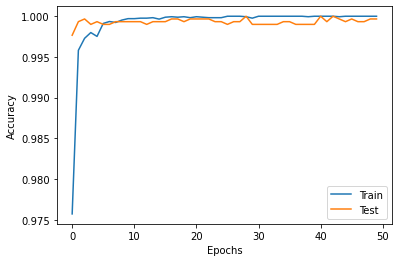

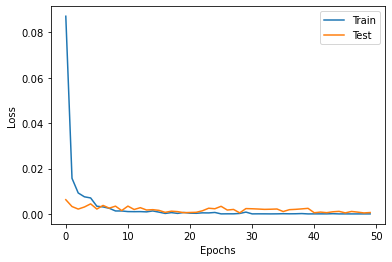

Text(0.5, 14.09375, 'Predicted Class')

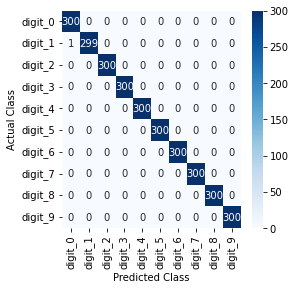

In [2]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = './Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
nb_train_samples = 17000
nb_validation_samples = 3000
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

# set seeds for reproduceability
np.random.seed(1)
tf.random.set_seed(1)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create a new model using lower layers of VGG16 upto block4_conv2,
# and mark as not trainable, i.e., freeze the lower layers
model = Sequential()
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained VGG16
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=13)
validation_generator = test_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=nb_validation_samples,
                    color_mode="rgb",
                    shuffle=False,
                    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
# model.save_weights('./results/HCR-Net-I.h5')

##################################
#### TRAINING PHASE - II #########
##################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
# model.save_weights('./results/HCR-Net-II.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
##############################################################################

In [3]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9996677740863789
recall_score   :  0.9996666666666666
f1_score       :  0.9996666657407381
accuracy_score :  0.9996666666666667

Best accuracy  :  1.0


0 1
Predicted class: digit_0  actual class: digit_1/39882.png digit_1


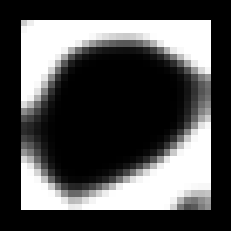

In [4]:
# miss-classification analysis (only this bit is new)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('dark_background')

validation_data_dir = validation_data_dir + '/'

image_names = validation_generator.filenames
image_classes = validation_generator.classes
class_dict = validation_generator.class_indices
class_dict = dict((v,k) for k,v in class_dict.items())

image_predicted = y_pred

for i in range(len(image_predicted)):
    if image_predicted[i] != image_classes[i]:
        print(image_predicted[i], image_classes[i])
        print('Predicted class:', class_dict[image_predicted[i]], ' actual class:', image_names[i], class_dict[image_classes[i]])
        img = Image.open(validation_data_dir + image_names[i]).convert("L")
        # maping image to gray scale
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
#         break;